# Finding Indicators of Heavy Traffic on Westbound I-94

I am going to analyze a dataset about the westbound traffic on the [I-94 Interstate highway](https://en.wikipedia.org/wiki/Interstate_94).

John Hogue made the dataset available, and you can download it from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume).

The goal of this analysis is to determine a few indicators of heavy traffic on I-94. These indicators can be weather type, time of the day, time of the week, etc. For instance, we may find out that the traffic is usually heavier in the summer or when it snows.

![map of 94](https://s3.amazonaws.com/dq-content/524/i94_figma.png)

## Dataset Information:
Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays are included for impacts on traffic volume.

*This means that the results of our analysis will be about the westbound traffic in the proximity of that station. In other words, we should avoid generalizing our results for the entire I-94 highway.*

### Variable Descriptions:
| Name                | Description                                                       |
|:---------------------|:-------------------------------------------------------------------|
| holiday             |  US National holidays plus regional holiday, Minnesota State Fair |
| temp                |  Average temp in kelvin                                           |
| rain_1h             |  Amount in mm of rain that occurred in the hour                   |
| snow_1h             |  Amount in mm of snow that occurred in the hour                   |
| clouds_all          |  Percentage of cloud cover                                        |
| weather_main        |  Short textual description of the current weather                 |
| weather_description |  Longer textual description of the current weather                |
| date_time           |  Hour of the data collected in local CST time                     |
| traffic_volume      |  Hourly I-94 ATR 301 reported westbound traffic volume            |

In [404]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt

In [405]:
traffic = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")

display(traffic.head())
display(traffic.tail())
display(traffic.info())

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


None

### Initial Observations:
- There are 9 variables with 48,204 entries. Each entry appears to represent a different hour of each day from 2012-10-02 to 2018-09-30
- There are no null values
- Temperature ("temp") is in Kelvins -- we will probably want to change this to a more common temperature unit like Fahrenheit (F) to make the analysis more understandable to the average person
- If the date_time variable is unique for each row we should consider setting that as the index

### Data Cleanup

In [406]:
#Converting the temperature column from Kelvins to Farenheit

def kelv_to_far(temp):
    return ((temp-273.15)*1.8)+32
traffic["temp"] = traffic["temp"].apply(kelv_to_far)
traffic = traffic.rename(columns={"temp":"temp_f"})

In [407]:
'''Changing the date_time variable to datetime format'''

traffic["date_time"] = pd.to_datetime(traffic["date_time"])


'''Adding a new column to the traffic dataframe that lists the time components 
separately from the datetime'''
traffic["hour"] = traffic["date_time"].dt.hour
traffic["date"] = traffic["date_time"].dt.date
traffic["year"] = traffic["date_time"].dt.year
traffic["month"] = traffic["date_time"].dt.month

For analysis further on in this notebook I wanted to check if there was even distribution of dates and it looks like the last half of 2014 and the first half of 2015 data is missing from the dataset. In the bar chart below you can see that 2014 and 2015 have half the count of dates that 2013, 2016, and 2017 do (which are the other completely included years -- 2012's data starts in October and 2018's data ends in October).

In the scatter plot below you can clearly see a gap in the data. While this shouldn't interefere with the ability to analyze traffic volume, it is interesting and important to note.

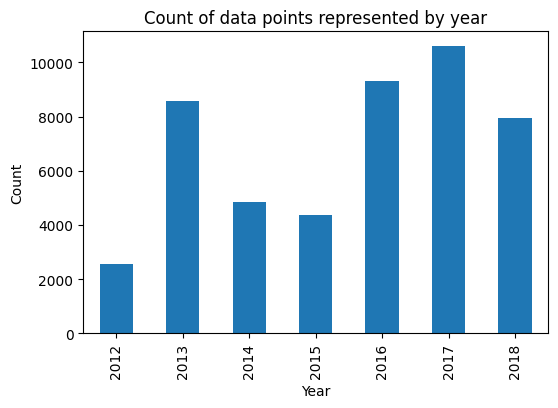

In [408]:
by_year = traffic["year"].groupby(traffic.year).agg("count")

by_year.plot.bar()
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Count of data points represented by year")
plt.show()

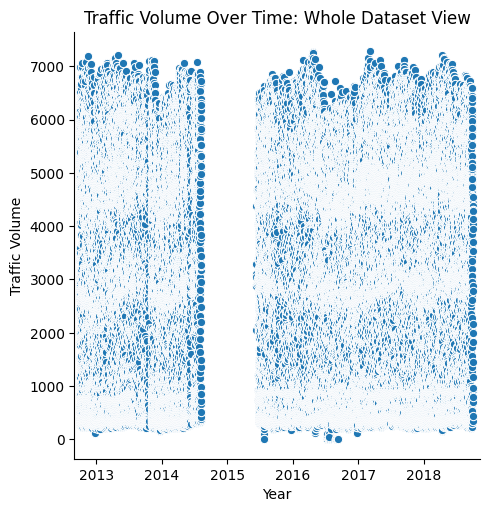

In [409]:
sns.relplot(data=traffic,x="date",y="traffic_volume")
plt.xlim(dt.date(2012,9,1),dt.date(2018,11,10))
plt.xlabel("Year")
plt.ylabel("Traffic Volume")
plt.title("Traffic Volume Over Time: Whole Dataset View")
plt.show()

*The following code cell is for the holiday data exploration which occurs later in this notebook. The original dataset only had the holiday indicated at the 00:00 timestamp, and we drop all instances of 00:00 later (therefore losing the holiday categorizations). In order to later do analysis on holiday impact on heavy traffic we are adding the holiday markers to all timestamps now.*

In [410]:
import numpy as np
unique_holidays = traffic["holiday"].unique()[1:]
unique_holidays

holiday_dates = traffic["date"][traffic["holiday"]!="None"].drop_duplicates()

holidays_temp = traffic.copy()[traffic["date"].isin(holiday_dates)]
holidays_temp = holidays_temp.replace("None",np.nan).ffill()

non_holidays_temp = traffic.copy()[~traffic["date"].isin(holiday_dates)]

traffic = pd.concat([holidays_temp,non_holidays_temp])

## Exploratory Analysis
Let's look at the distribution and summary statistics of traffic volume to see if we can find any patterns

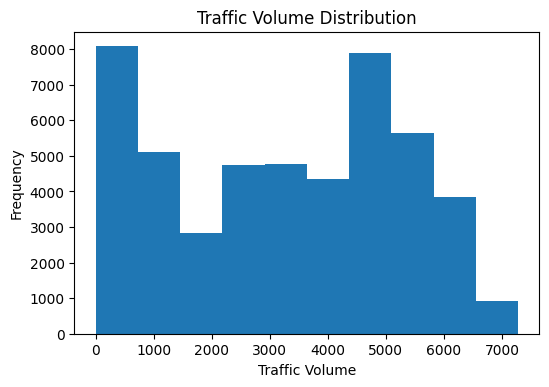

In [411]:
traffic["traffic_volume"].plot.hist()
plt.xlabel("Traffic Volume")
plt.title("Traffic Volume Distribution")
plt.show()

In [412]:
traffic["traffic_volume"].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

Looking at the traffic volume variable ("traffic_volume") it looks like there are two peaks: one when there is very little traffic (0-500 cars) and one when there is a substantial amount of traffic (4500-5000 cars). This could potentially be affected by the time of day, so let's look more closely at the datetime variable and try to create a way to discern day vs. night.

### Time Indicators
In order to look more closely at day vs night to see if they are indicators of heavy traffic we need to classify whether the hour is a "day" hour or "night" hour. For the beginning of this exploration we will classify "day" as 7am-6pm (inclusive) and "night" as 7pm-6am (inclusive).

In [413]:
'''Adding a new column to the traffic dataframe that categorizes the time 
as day or night'''

temp = []
for hour in traffic["hour"]:
    if (hour >= 7) & (hour <19):
        temp.append("day")
    else:
        temp.append("night")
        
traffic["daynight"]=temp

'''Creating separate dataframes from day and night so we can 
compare side-by-side'''
daydf = traffic.copy()[traffic["daynight"]=="day"]
nightdf = traffic.copy()[traffic["daynight"]=="night"]

Now that day and night have been separated let's look at their individual distributions and summary statistics:

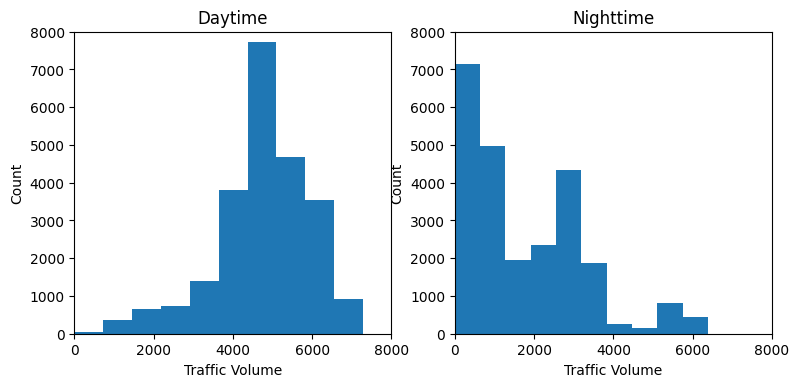

In [414]:
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
daydf["traffic_volume"].plot.hist()
plt.title("Daytime")
plt.xlabel("Traffic Volume")
plt.ylabel("Count")
plt.xlim(0,8000)
plt.ylim(0,8000)

plt.subplot(1,2,2)
nightdf["traffic_volume"].plot.hist()
plt.title("Nighttime")
plt.xlabel("Traffic Volume")
plt.ylabel("Count")
plt.xlim(0,8000)
plt.ylim(0,8000)

plt.show()

In [415]:
print("Daytime Describe")
display(daydf["traffic_volume"].describe())
print("Nighttime Describe")
display(nightdf["traffic_volume"].describe())

Daytime Describe


count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

Nighttime Describe


count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64

#### Day vs Night
When daytime and nighttime hours are separated we can see from the histograms and summary statistics that daytime traffic volume is much higher than nighttime traffic volume.

Day time is a fairly normal distribution of traffic volume, with the most instances of volume being between 4500 and 5000 cars. The mean (4762) for daytime is also very close to the median (4820) with the difference between them being ~60, which helps solidify the normal distribution.

Night time is a left-skewed distribution, with the majority of instances being between 0 and 500 cars. This is confirmed by the comparison of mean (1785) and median (1287), which have a differences of ~500.

Since heavy traffic volume occurs most frequently during the day and the distribution is normal we will consider removing the nighttime data from the dataset for determining indicators of heavy traffic. Before we do this let's look at heavy daytime vs heavy nighttime traffic (separated from their original dataframes by using the traffic_volume average for daytime data).

In [416]:
dayheavy = daydf.copy()[daydf["traffic_volume"]>4762]
nightheavy = nightdf.copy()[nightdf["traffic_volume"]>4762]

display(dayheavy.describe())
display(nightheavy.describe())

,temp_f,rain_1h,snow_1h,clouds_all,traffic_volume,hour,year,month
count,12597.000000,12597.000000,12597.000000,12597.000000,12597.000000,12597.000000,12597.000000,12597.000000
mean,50.258179,0.891285,0.000389,51.762324,5590.236405,12.478447,2015.485195,6.468762
std,22.203627,87.597637,0.011812,37.556309,591.983236,3.463774,1.915044,3.255659
min,-16.168000,0.000000,0.000000,0.000000,4763.000000,7.000000,2012.000000,1.000000
25%,33.800000,0.000000,0.000000,5.000000,5064.000000,9.000000,2014.000000,4.000000
50%,53.060000,0.000000,0.000000,75.000000,5490.000000,13.000000,2016.000000,6.000000
75%,68.504000,0.000000,0.000000,90.000000,6050.000000,15.000000,2017.000000,9.000000
max,97.052000,9831.300000,0.510000,100.000000,7280.000000,18.000000,2018.000000,12.000000


,temp_f,rain_1h,snow_1h,clouds_all,traffic_volume,hour,year,month
count,1348.000000,1348.000000,1348.0,1348.000000,1348.000000,1348.000000,1348.000000,1348.000000
mean,43.086334,0.150067,0.0,44.833086,5584.743323,6.022997,2015.581602,6.501484
std,24.340003,0.856235,0.0,40.638459,298.358438,0.597127,1.855193,3.230446
min,-459.670000,0.000000,0.0,0.000000,4763.000000,6.000000,2012.000000,1.000000
25%,30.299000,0.000000,0.0,1.000000,5409.000000,6.000000,2014.000000,4.000000
50%,46.634000,0.000000,0.0,40.000000,5608.000000,6.000000,2016.000000,7.000000
75%,60.687500,0.000000,0.0,90.000000,5805.000000,6.000000,2017.000000,9.000000
max,77.288000,10.050000,0.0,100.000000,6386.000000,22.000000,2018.000000,12.000000


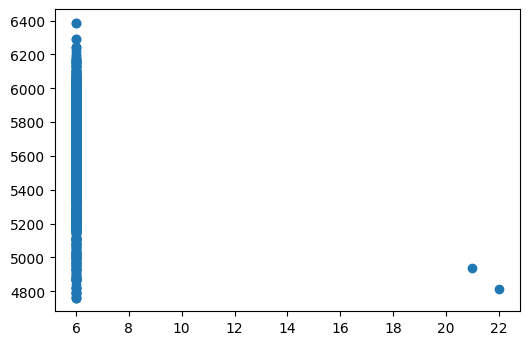

In [417]:
plt.scatter(nightheavy["hour"],nightheavy["traffic_volume"])
plt.show()

After looking more closely at the "heavy" traffic volumes for day and night separately, it appears that nearly all cases of heavy "night time" traffic volume occur at 6am. Since 6am can be considered "day" (when many people begin commuting for work, for example) we should reevaluate our distinction of day vs night to include 6am in the "day" dataset. Since the night data without 6am will have very few heavy traffic volume instances it should be removed from the dataset for the purposes of analyzing indicators of heavy traffic.

In [418]:
traffic = traffic.copy()[traffic["hour"].between(6,19,inclusive=True)]

In [419]:
traffic.describe()

,temp_f,rain_1h,snow_1h,clouds_all,traffic_volume,hour,year,month
count,27925.000000,27925.000000,27925.000000,27925.000000,27925.000000,27925.000000,27925.000000,27925.000000
mean,48.017152,0.479331,0.000220,52.464924,4611.267574,12.412032,2015.511012,6.522399
std,24.199747,58.838607,0.008198,37.876070,1294.808371,4.054214,1.898211,3.401294
min,-459.670000,0.000000,0.000000,0.000000,0.000000,6.000000,2012.000000,1.000000
25%,30.974000,0.000000,0.000000,1.000000,3992.000000,9.000000,2014.000000,4.000000
50%,50.615600,0.000000,0.000000,75.000000,4761.000000,12.000000,2016.000000,7.000000
75%,67.946000,0.000000,0.000000,90.000000,5521.000000,16.000000,2017.000000,9.000000
max,98.456000,9831.300000,0.510000,100.000000,7280.000000,19.000000,2018.000000,12.000000


Looking at the temparature variable the minimum temperature is -459.67, which is clearly a data quality issue. Let's examine these outliers more closely by filtering for temperatures that are lower than have been recorded in Minnesota since 2012 (lowest recorded temp was -31 -- yikes!).

In [420]:
traffic[traffic["temp_f"]<-31]

,holiday,temp_f,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,hour,date,year,month,daynight
11901,None,-459.67,0.0,0.0,0,Clear,sky is clear,2014-01-31 06:00:00,5150,6,2014-01-31,2014,1,night
11949,None,-459.67,0.0,0.0,0,Clear,sky is clear,2014-02-02 06:00:00,739,6,2014-02-02,2014,2,night
11950,None,-459.67,0.0,0.0,0,Clear,sky is clear,2014-02-02 07:00:00,962,7,2014-02-02,2014,2,day
11951,None,-459.67,0.0,0.0,0,Clear,sky is clear,2014-02-02 08:00:00,1670,8,2014-02-02,2014,2,day


We can see from the data abole that there are 4 instances of the temperature (F) that are -459.67. This is because these values were 0 in the original dataset when the temperature was still in Kelvins. 0 in these instances probably indicate either 1) the temperature was originally recorded in Farenheit/Celsius instead of Kelvins or 2) the data was missing. Because it is only 4 values we will drop these rows from the dataset since we can't be sure of the accuracy of the other values in these rows.

In [421]:
traffic = traffic.copy()[traffic["temp_f"]>=-31]
traffic.describe()

,temp_f,rain_1h,snow_1h,clouds_all,traffic_volume,hour,year,month
count,27921.000000,27921.000000,27921.000000,27921.000000,27921.000000,27921.000000,27921.000000,27921.000000
mean,48.089884,0.479400,0.000220,52.472440,4611.623008,12.412843,2015.511228,6.523083
std,23.426053,58.842821,0.008198,37.873576,1294.385765,4.053926,1.898260,3.401054
min,-21.568000,0.000000,0.000000,0.000000,0.000000,6.000000,2012.000000,1.000000
25%,30.992000,0.000000,0.000000,1.000000,3993.000000,9.000000,2014.000000,4.000000
50%,50.630000,0.000000,0.000000,75.000000,4761.000000,12.000000,2016.000000,7.000000
75%,67.946000,0.000000,0.000000,90.000000,5521.000000,16.000000,2017.000000,9.000000
max,98.456000,9831.300000,0.510000,100.000000,7280.000000,19.000000,2018.000000,12.000000


#### Month, Day, and Hour
Previously, we determined that the traffic at night is generally light. Our goal is to find indicators of heavy traffic, so we decided to only focus on the daytime data moving forward.

One of the possible indicators of heavy traffic is time. There might be more people on the road in a certain month, on a certain day, or at a certain time of the day.

We're going to look at a few line plots showing how the traffic volume changed according to the following parameters:

- Month
- Day of the week
- Time of day

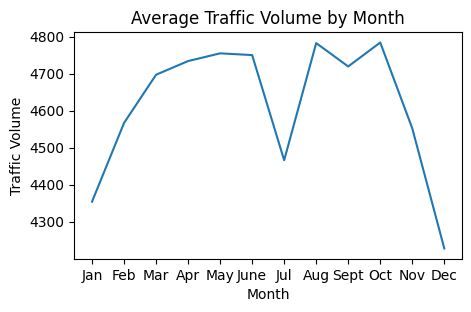

In [422]:
traffic["month"] = traffic["date_time"].dt.month
by_month_avg = traffic.groupby("month").mean()
by_month_count = traffic.groupby("month").sum()
plt.figure(figsize=(5,3))
plt.plot(by_month_avg["traffic_volume"])
plt.xticks(ticks=[1,2,3,4,5,6,7,8,9,10,11,12],labels=["Jan","Feb","Mar","Apr"
                                                     ,"May","June","Jul","Aug"
                                                     ,"Sept","Oct","Nov","Dec"])
plt.xlabel("Month")
plt.ylabel("Traffic Volume")
plt.title("Average Traffic Volume by Month")
plt.show()

It looks like three months have lower traffic volume on average:
- January
- July
- December

December in particular has a very low traffic volume compared to the other months (average of 4375). July looks like a potential anomaly in this dataset and further analysis into July should be considered.

Now that we have looked at traffic by month, let's narrow the scope to see if certain days of week have more traffic volume than others:

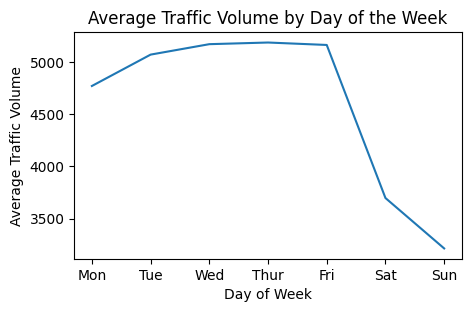

In [423]:
traffic["dayofweek"] = traffic["date_time"].dt.dayofweek
by_dayofweek = traffic.groupby("dayofweek").mean()

plt.figure(figsize=(5,3))
by_dayofweek["traffic_volume"].plot.line()
plt.xticks(ticks = [0,1,2,3,4,5,6],
           labels=["Mon","Tue","Wed","Thur","Fri","Sat","Sun"])
plt.xlabel("Day of Week")
plt.ylabel("Average Traffic Volume")
plt.title("Average Traffic Volume by Day of the Week")
plt.show()

We can see that there is a big difference in traffic volume on weekend days (Saturday and Sunday), with the average traffic volume being at least 1000 fewer cars than on weekdays.

We'll now generate a line plot for the time of day. The weekends, however, will drag down the average values, so we're going to look at the averages separately. To do that, we'll start by splitting the data based on the day type: business day or weekend.

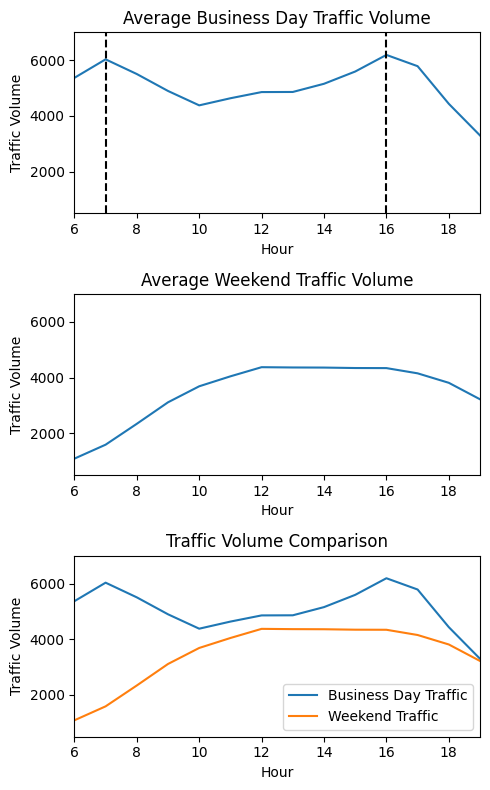

In [424]:
business_days = traffic.copy()[traffic["dayofweek"]<=4]
weekend = traffic.copy()[traffic["dayofweek"]>=5]
by_hour_business = business_days.groupby("hour").mean()
by_hour_weekend = weekend.groupby("hour").mean()

plt.figure(figsize=(5,8))

plt.subplot(3,1,1)
by_hour_business["traffic_volume"].plot.line()
plt.title("Average Business Day Traffic Volume")
plt.xlabel("Hour")
plt.ylabel("Traffic Volume")
plt.xlim(6,19)
plt.ylim(500,7000)
plt.axvline(x=7,linestyle="--",color="k")
plt.axvline(x=16,linestyle="--",color="k")

plt.subplot(3,1,2)
by_hour_weekend["traffic_volume"].plot.line()
plt.title("Average Weekend Traffic Volume")
plt.xlabel("Hour")
plt.ylabel("Traffic Volume")
plt.xlim(6,19)
plt.ylim(500,7000)

plt.subplot(3,1,3)
plt.plot(by_hour_business["traffic_volume"],label="Business Day Traffic")
plt.plot(by_hour_weekend["traffic_volume"],label="Weekend Traffic")
plt.legend()
plt.title("Traffic Volume Comparison")
plt.xlabel("Hour")
plt.ylabel("Traffic Volume")
plt.xlim(6,19)
plt.ylim(500,7000)

plt.tight_layout()
plt.show()

The graphs show two peaks for business day traffic volume: "rush hour" occurs Monday-Friday at 7am and 4pm. The weekend tends to have less traffic overall than weekdays, but there is slightly more traffic during afternoon hours on the weekend than during the morning. This makes sense because people may sleep in or not yet be out and about early in the morning on their days off.

#### Here are the overall conclusions we can draw based on time indicators:
- Traffic is usually heavier in March-October (warmer months), with the exception of the July anomaly
- Traffic is usually heavier on business days compared to weekends
- Traffic is usually heaviest during "rush hour" on business days at 7am and 4pm

### Weather Indicators

Now that we have explored the date/time variables in relation to traffic volume, let's look at another possible indicator: weather.

Some of the weather variables are numeric so we will start by looking at correlation.

In [425]:
traffic_corr_matrix = traffic.corr()
traffic_corr_matrix["traffic_volume"].sort_values(ascending=False)

traffic_volume    1.000000
temp_f            0.115112
hour              0.040221
snow_1h           0.003780
rain_1h           0.003611
year              0.002122
month            -0.016572
clouds_all       -0.025108
dayofweek        -0.407637
Name: traffic_volume, dtype: float64

The strongest correlation from weather-related numeric variables is temperature (Farenheit) with a correlation coefficient of 0.115. This is still a fairly weak correlation though.

The other weather-related numeric variables are very weak correlations, with none higher than 0.04.

Since none of the numeric variables have very high correlations, let's look at the categorical variables: **weather_main** and **weather_description**

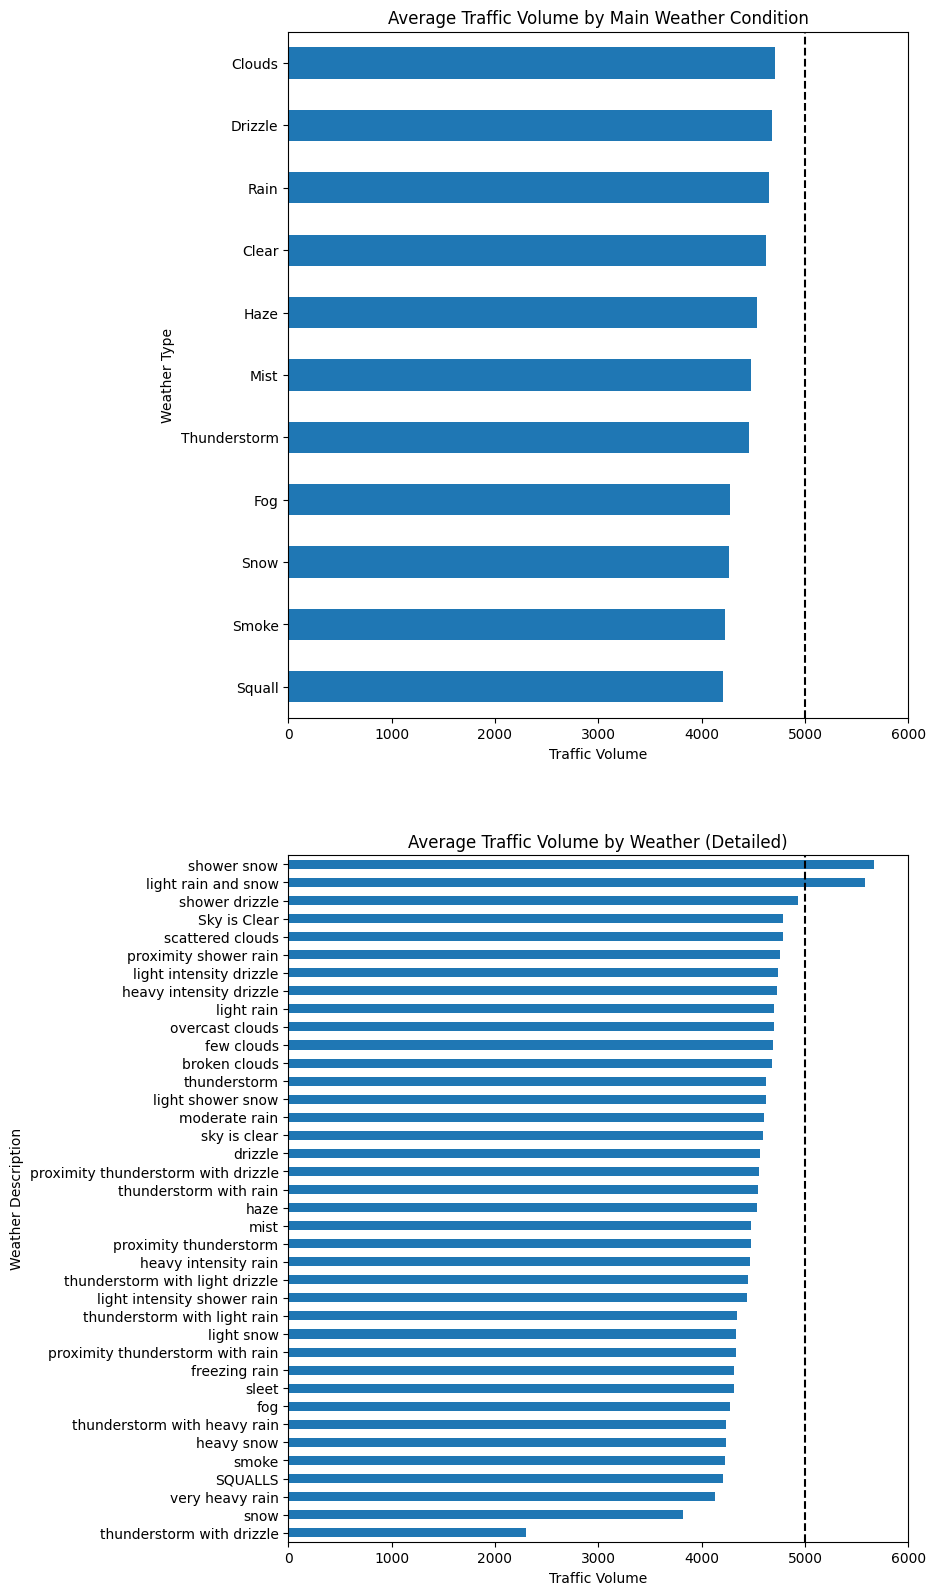

In [426]:
by_weather_main = traffic.groupby(
    "weather_main").mean().sort_values(by="traffic_volume")
by_weather_description = traffic.groupby(
    "weather_description").mean().sort_values(by="traffic_volume")

plt.figure(figsize=(8,20))
plt.subplot(2,1,1)
by_weather_main["traffic_volume"].plot.barh()
plt.xlabel("Traffic Volume")
plt.ylabel("Weather Type")
plt.xlim(0,6000)
plt.axvline(x=5000,linestyle="--",color="k")
plt.title("Average Traffic Volume by Main Weather Condition")

plt.subplot(2,1,2)
by_weather_description["traffic_volume"].plot.barh()
plt.xlabel("Traffic Volume")
plt.ylabel("Weather Description")
plt.xlim(0,6000)
plt.axvline(x=5000,linestyle="--",color="k")
plt.title("Average Traffic Volume by Weather (Detailed)")
plt.show()

There are two weather events that lead to substatially more traffic than others:
- shower snow
- light rain and snow

Let's take a closer look at these events to see if we can conclude that they are indicators for heavy traffic:

In [427]:
weather_indicators=traffic.copy()[
    (traffic["weather_description"]=="shower snow") |
    (traffic["weather_description"]=="light rain and snow")]

In [428]:
weather_indicators

,holiday,temp_f,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,hour,date,year,month,daynight,dayofweek
4302,None,23.954,0.00,0.0,90,Snow,shower snow,2013-03-15 07:00:00,5664,7,2013-03-15,2013,3,day,4
5430,None,39.146,0.00,0.0,90,Snow,light rain and snow,2013-04-23 15:00:00,5544,15,2013-04-23,2013,4,day,1
5439,None,35.600,0.00,0.0,90,Snow,light rain and snow,2013-04-23 17:00:00,6345,17,2013-04-23,2013,4,day,1
10355,None,34.070,1.27,0.0,64,Snow,light rain and snow,2013-12-03 13:00:00,4739,13,2013-12-03,2013,12,day,1
19198,None,36.878,0.00,0.0,90,Snow,light rain and snow,2015-10-28 15:00:00,5691,15,2015-10-28,2015,10,day,2


Because there are only a few instances of shower snow/light rain and snow in the entire dataset of over 20,000 instances I am hesitant to conclude that these are definitely indicators of heavy traffic. Let's look at the overall value counts for weather types to see if we can get a better idea of how common different instances are.

In [429]:
weather_main_counts = traffic["weather_main"].value_counts()

weather_desc_counts = traffic["weather_description"].value_counts()

In [430]:
main_weather=pd.merge(by_weather_main,weather_main_counts,
                      left_index=True,right_index=True)
main_weather = main_weather.rename(columns={"weather_main":"count"})

desc_weather = pd.merge(by_weather_description,weather_desc_counts,
                        left_index=True,right_index=True)
desc_weather = desc_weather.rename(columns={"weather_description":"count"})

In [431]:
main_weather.loc[:,~main_weather.columns.isin(["hour","month","dayofweek"])]

,temp_f,rain_1h,snow_1h,clouds_all,traffic_volume,year,count
Squall,74.444000,1.020000,0.000000,75.000000,4211.000000,2016.000000,1
Smoke,65.696000,0.752857,0.000000,48.642857,4225.857143,2015.857143,14
Snow,22.716107,0.012258,0.001557,80.833036,4267.254308,2015.497920,1683
Fog,40.930056,0.138168,0.001099,60.482759,4273.355603,2015.812500,464
Thunderstorm,68.204525,1.186849,0.000000,73.218579,4461.795993,2016.222222,549
Mist,43.482411,0.252460,0.000695,72.253651,4480.231746,2015.543492,3150
Haze,36.278332,0.059110,0.000000,62.799131,4533.549403,2015.609121,921
Clear,50.301368,0.000000,0.000000,1.653431,4621.569343,2015.619854,6850
Rain,57.073139,3.473549,0.000248,75.522442,4655.746559,2015.574207,3342
Drizzle,52.240812,0.170295,0.000000,84.381179,4681.174905,2015.886882,1052


In [432]:
desc_weather.loc[:,~desc_weather.columns.isin(["hour","month","dayofweek"])]

,temp_f,rain_1h,snow_1h,clouds_all,traffic_volume,year,count
thunderstorm with drizzle,58.514000,5.345000,0.000000,90.000000,2297.000000,2014.500000,2
snow,27.719183,0.020671,0.003110,88.695122,3815.085366,2015.713415,164
very heavy rain,66.742000,1114.202222,0.000000,48.333333,4130.777778,2014.333333,9
SQUALLS,74.444000,1.020000,0.000000,75.000000,4211.000000,2016.000000,1
smoke,65.696000,0.752857,0.000000,48.642857,4225.857143,2015.857143,14
heavy snow,24.922537,0.002060,0.000000,85.360434,4234.441734,2013.170732,369
thunderstorm with heavy rain,67.578200,3.058000,0.000000,81.566667,4240.500000,2015.166667,30
fog,40.930056,0.138168,0.001099,60.482759,4273.355603,2015.812500,464
sleet,36.674000,0.000000,0.000000,90.000000,4312.666667,2017.000000,3
freezing rain,31.478000,0.000000,0.000000,90.000000,4314.000000,2014.500000,2


From the count and mean dataframes above it isn't clear that one single weather event is a good indicator of heavy traffic.

## Do holidays impact traffic?
Let's explore if holidays impact traffic

In [433]:
holidays = traffic.copy()[traffic["holiday"]!="None"]
non_holidays = traffic.copy()[traffic["holiday"]=="None"]

In [434]:
grouped_holidays = holidays.groupby("holiday").mean().sort_values("traffic_volume")
grouped_non_holidays = non_holidays.mean()

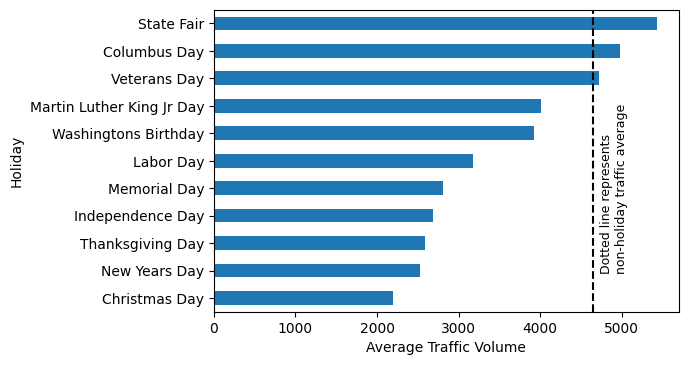

In [435]:
grouped_holidays["traffic_volume"].plot.barh()
plt.axvline(x=grouped_non_holidays["traffic_volume"],linestyle="--",color="k")
plt.xlabel("Average Traffic Volume")
plt.ylabel("Holiday")
plt.text(4730,1,'Dotted line represents \nnon-holiday traffic average',fontsize=9,rotation=90)
plt.show()

In general it seems like holidays mean *less* traffic on the road than non-holidays, as can be see from the dotted line with the non-holiday average in the graph above. The big exception to this is the State Fair, which could be because the fair is something that many people need to take the I-94 to get to compared to other holidays where car travel is either more local or more spread out (i.e. not everyone uses the I-94).

Now let's visualize the traffic indicators we determined as contributing to heavy traffic:

In [436]:
def rush_hour(row):
    if  row["holiday"] != "None":
        return "holiday"
    elif (row["dayofweek"] == 5) | (row["dayofweek"] == 6):
        return "weekend"
    elif (row["hour"] == 7) | (row["hour"] == 16):
        return "rush hour"
    else:
        return "not rush hour"
traffic["time_type"]=traffic.apply(lambda row: rush_hour(row), axis=1)

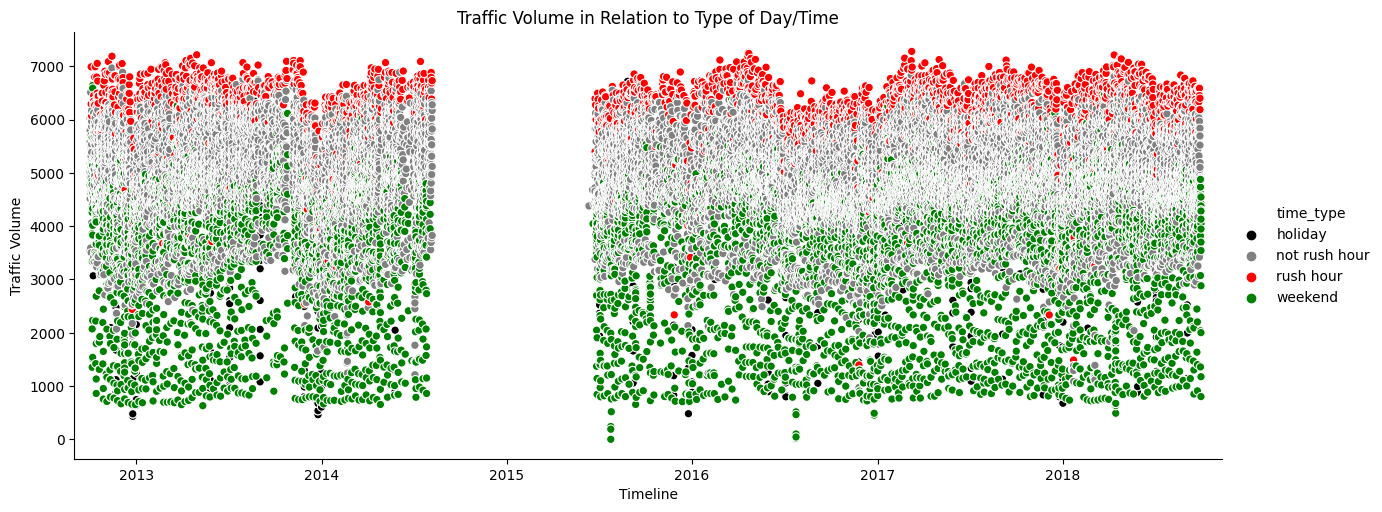

In [445]:
palette = {"holiday":"black","rush hour":"red","weekend":"green","not rush hour":"grey"}

sns.relplot(data=traffic,x="date",y="traffic_volume",height=5,aspect=2.5,hue="time_type",palette=palette,legend="brief")
plt.xlim(dt.date(2012,9,1),dt.date(2018,11,10))
plt.xlabel("Timeline")
plt.ylabel("Traffic Volume")
plt.title("Traffic Volume in Relation to Type of Day/Time")
plt.show()

*Note that the gap in the graph above is due to missing data from the original dataset*

## Conclusion

**Time Indicators:**
As we can see from the graph above, rush hour on weekdays is the busiest time on westbound I-94. Weekdays between the hours of 6am and 6pm were the next busiest traffic times. Night time hours were not busy for traffic (so much so that we removed these hours from our dataset for the rest of the analysis).

**Weather Indicators:**
After reviewing several potential indicators of heavy traffic it appears that the weather data provided in this dataset does not support the idea that weather events impact traffic rates. I found this surprising since personal experience would indicate that rain and snow lead to slower cars and more traffic congestion. The only weather events with exceptionally high traffic volume had very few instances in the dataset which means that they could easily be shifted by a single outlier and should not be used for generalizing conclusions.

**Holidays:**
This dataset was messy with how it originally coded holidays since the holiday name was only listed in rows where the date/time cell had a time of 00:00 (midnight). After filling all corresponding rows with the holiday labels where appropriate it seems that in general holidays lead to lighter traffic but there are three large exceptions: the State Fair, Colombus Day, and Veterans Day.


### Future Ideas
This dataset offers a lot of room for additional discovery. For example there is more than one row assigned to some date/time values due to that hour having multiple weather events simultaneously (i.e. 7/23/2016 at 11am has a main weather of "rain" and a main weather of "thunderstorms"). This makes me wonder if simplifying and deduplicating date/time values would lead to different conclusions about weather events in relation to traffic volume.

I would also like to explore cumulative rainfall or snowfall and it's impact on traffic because looking at rainfall in millimeters over the course of an hour could be a very different driving experience if the rain just started versus if it had been raining consistently for hours and flooding occurred.